# Description

TODO

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib_venn as mv
import seaborn as sns

from entity import Trait, Gene
from data.cache import read_data
import conf

# Settings

In [3]:
# EXPERIMENT_NAME = "single_gene"

# LIPIDS_GENE_SET = "gene_set_increase"
# LIPIDS_GENE_SET_QUERY = "(rank == 3) | (rank == 2)"

In [4]:
OUTPUT_DIR = Path(
    conf.RESULTS["CRISPR_ANALYSES"]["BASE_DIR"], f"analyses"
)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
display(OUTPUT_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/crispr_analyses/analyses')

# Data loading

## LV

In [5]:
lv_traits = pd.read_pickle(Path(conf.RESULTS["CRISPR_ANALYSES"]["BASE_DIR"], "lv-gene_set_decrease", "traits.pkl").resolve())

In [6]:
lv_traits.shape

(3752, 3)

In [7]:
lv_traits.head()

,trait,value,category
0,celiac disease,0.776903,Diseases (gastrointestinal/abdominal)
1,4079_raw-Diastolic_blood_pressure_automated_re...,0.722681,Blood pressure
2,30280_raw-Immature_reticulocyte_fraction,0.696531,Blood count
3,20003_1140888390-Treatmentmedication_code_ferr...,0.696229,Medications
4,6150_100-Vascularheart_problems_diagnosed_by_d...,0.660706,Diseases (cardiovascular)


In [8]:
lv_traits_categories = (
    lv_traits.groupby("category")
    .mean()
    .sort_values("value", ascending=False)
    .reset_index()
)

In [9]:
lv_traits_categories.shape

(122, 2)

In [10]:
lv_traits_categories.head()

,category,value
0,Blood pressure,0.496839
1,Blood,0.448728
2,Impedance measures,0.437653
3,Bone-densitometry of heel,0.425231
4,Blood count,0.419441


## Single gene

In [11]:
sg_traits = pd.read_pickle(Path(conf.RESULTS["CRISPR_ANALYSES"]["BASE_DIR"], "single_gene-gene_set_decrease", "traits.pkl").resolve())

In [12]:
sg_traits.shape

(3752, 3)

In [13]:
sg_traits.head()

,trait,value,category
0,6150_4-Vascularheart_problems_diagnosed_by_doc...,0.005252,Diseases (cardiovascular)
1,4079_raw-Diastolic_blood_pressure_automated_re...,0.005248,Blood pressure
2,hypertension,0.005163,Diseases (cardiovascular)
3,ASTHMA_EOSINOPHIL_SUGG-Suggestive_for_eosinoph...,0.005096,Diseases (FinnGen)
4,6153_2-Medication_for_cholesterol_blood_pressu...,0.005081,Medication


In [14]:
sg_traits_categories = (
    sg_traits.groupby("category")
    .mean()
    .sort_values("value", ascending=False)
    .reset_index()
)

In [15]:
sg_traits_categories.shape

(122, 2)

In [16]:
sg_traits_categories.head()

,category,value
0,Blood pressure,0.004729
1,Hand grip strength,0.004636
2,Anthropometric,0.004595
3,Body size measures,0.004465
4,Impedance measures,0.004438


# Categorize traits

In [104]:
trait_categories_map = {
#     "body height": "Body size measures",
    
    "6150_4-Vascularheart_problems_diagnosed_by_doctor_High_blood_pressure": "Hypertension",
    "hypertension": "Hypertension",
    
    "atherosclerosis": "Cardiovascular diseases",
    "DM_PERIPHATHERO-Peripheral_atherosclerosis": "Cardiovascular diseases",
    
    "I9_UAP-Unstable_angina_pectoris": "Heart diseases",
    "bundle branch block": "Heart diseases", # also CVD
    "I9_AVBLOCK-AVblock": "Heart diseases", # also CVD
    "I9_CONDUCTIO-Conduction_disorders": "Heart diseases", # also CVD
    
    "H7_EPIPHORA-Epiphora": "Eye problems",
    
    "C3_SKIN-Malignant_neoplasm_of_skin": "Skin cancers",
    "C_SKIN": "Skin cancers",
    "C_OTHER_SKIN-Other_malignant_neoplasms_of_skin": "Skin cancers",
    
    "ASTHMA_EOSINOPHIL_SUGG-Suggestive_for_eosinophilic_asthma": "Respiratory diseases",
    "J20-Diagnoses_main_ICD10_J20_Acute_bronchitis": "Respiratory diseases",
    "pleural empyema": "Respiratory diseases",
    
    "RHEUMA_SEROPOS-Seropositive_rheumatoid_arthritis": "Autoimmune diseases",
    "RHEUMA_SEROPOS_OTH-Otherunspecified_seropositiverheumatoid_arthritis": "Autoimmune diseases",
    "celiac disease": "Autoimmune diseases",
    "K11_COELIAC-Coeliac_disease": "Autoimmune diseases",
    "malabsorption syndrome": "Autoimmune diseases", # this one comes from ICD10 K00, which is mainly "celiac disease"
    
    "22507_raw-Age_of_stopping_smoking": "Smoking",
    "22506_112-Tobacco_smoking_Occasionally": "Smoking",
    
    "diabetes mellitus": "Diseases (endocrine/diabetes)",
    
    "20090_360-Type_of_fatoil_used_in_cooking_Spreadable_butter": "Diet",
    "103060-Poultry_intake": "Diet",
    "104460-Banana_intake": "Diet",
    "100920_2105-Type_milk_consumed_soya_with_calcium": "Diet",
}

categories_map = {
    "Blood": "Blood count",
    "Diseases (cardiovascular)": "Cardiovascular diseases",
    "Diseases (respiratory/ent)": "Respiratory diseases",
    "Diseases (FinnGen)": "Other diseases/disorders",
    "Diseases (ICD10 main)": "Other diseases/disorders",
    "Employment history": "Employment",
    "Medication": "Medications",
}

def _assign_category(x):
    trait_name = x["trait"]
    if trait_name in trait_categories_map:
        trait_categ = trait_categories_map[trait_name]
    else:
        trait_categ = x["category"]
    
    if trait_categ in categories_map:
        return categories_map[trait_categ]
    
    return trait_categ

In [150]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "max_colwidth", None
):
    _tmp = lv_traits.assign(category=lv_traits.apply(_assign_category, axis=1))
    display(_tmp.head(100))

,trait,value,category
0,celiac disease,0.776903,Autoimmune diseases
1,4079_raw-Diastolic_blood_pressure_automated_reading,0.722681,Blood pressure
2,30280_raw-Immature_reticulocyte_fraction,0.696531,Blood count
3,20003_1140888390-Treatmentmedication_code_ferrous_salt_product,0.696229,Medications
4,6150_100-Vascularheart_problems_diagnosed_by_doctor_None_of_the_above,0.660706,Cardiovascular diseases
5,30110_raw-Platelet_distribution_width,0.647184,Blood count
6,I9_UAP-Unstable_angina_pectoris,0.646180,Heart diseases
7,6150_4-Vascularheart_problems_diagnosed_by_doctor_High_blood_pressure,0.633882,Hypertension
8,30170-Nucleated_red_blood_cell_count,0.618583,Blood count
9,malabsorption syndrome,0.615291,Autoimmune diseases


In [139]:
_n_top = 50

_lv_tmp = lv_traits.head(_n_top).assign(category=lv_traits.apply(_assign_category, axis=1)).assign(group="lv")
_lv_tmp["value"] = _lv_tmp["value"] / _lv_tmp["value"].max()

_sg_tmp = sg_traits.head(_n_top).assign(category=sg_traits.apply(_assign_category, axis=1)).assign(group="single-gene")
_sg_tmp["value"] = _sg_tmp["value"] / _sg_tmp["value"].max()

In [140]:
_all_tmp = pd.concat((_lv_tmp, _sg_tmp), ignore_index=True)

In [141]:
_all_tmp.shape

(100, 4)

In [142]:
_all_tmp.head()

,trait,value,category,group
0,celiac disease,1.000000,Autoimmune diseases,lv
1,4079_raw-Diastolic_blood_pressure_automated_re...,0.930208,Blood pressure,lv
2,30280_raw-Immature_reticulocyte_fraction,0.896548,Blood count,lv
3,20003_1140888390-Treatmentmedication_code_ferr...,0.896159,Medications,lv
4,6150_100-Vascularheart_problems_diagnosed_by_d...,0.850435,Cardiovascular diseases,lv


In [143]:
_cat_order = _all_tmp.groupby(["group", "category"])["value"].max().sort_values(ascending=False)

In [144]:
_cat_order.loc["lv"].head(10)

category
Autoimmune diseases        1.000000
Blood pressure             0.930208
Blood count                0.896548
Medications                0.896159
Cardiovascular diseases    0.850435
Heart diseases             0.831739
Hypertension               0.815910
Male-specific factors      0.777568
Smoking                    0.749467
Skin cancers               0.748264
Name: value, dtype: float64

In [145]:
_cat_order.loc["single-gene"].head(10)

category
Hypertension                1.000000
Blood pressure              0.999189
Respiratory diseases        0.970311
Medications                 0.967521
Spirometry                  0.958168
Cardiovascular diseases     0.957837
Blood count                 0.946210
Employment                  0.934696
Other diseases/disorders    0.931784
Body size measures          0.925671
Name: value, dtype: float64

In [146]:
_final_cat_order = pd.concat((
    _cat_order.loc["lv"].head(10),
    _cat_order.loc["single-gene"].head(10),
))

In [147]:
_final_cat_order.sort_values(ascending=False)

category
Autoimmune diseases         1.000000
Hypertension                1.000000
Blood pressure              0.999189
Respiratory diseases        0.970311
Medications                 0.967521
Spirometry                  0.958168
Cardiovascular diseases     0.957837
Blood count                 0.946210
Employment                  0.934696
Other diseases/disorders    0.931784
Blood pressure              0.930208
Body size measures          0.925671
Blood count                 0.896548
Medications                 0.896159
Cardiovascular diseases     0.850435
Heart diseases              0.831739
Hypertension                0.815910
Male-specific factors       0.777568
Smoking                     0.749467
Skin cancers                0.748264
Name: value, dtype: float64

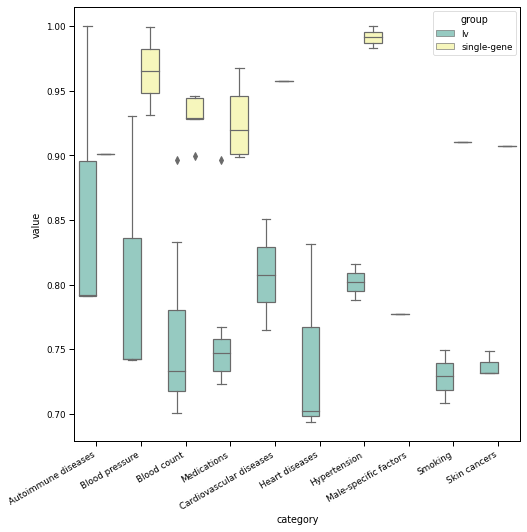

In [148]:
with sns.plotting_context("paper"):
    f, ax = plt.subplots(figsize=(8, 8))  # (figsize=(8, 8))
    ax = sns.boxplot(
        x="category",
        y="value",
        hue="group",
        order=_final_cat_order.index[:10].tolist(),
        data=_all_tmp,
        palette="Set3",
        ax=ax
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment="right")

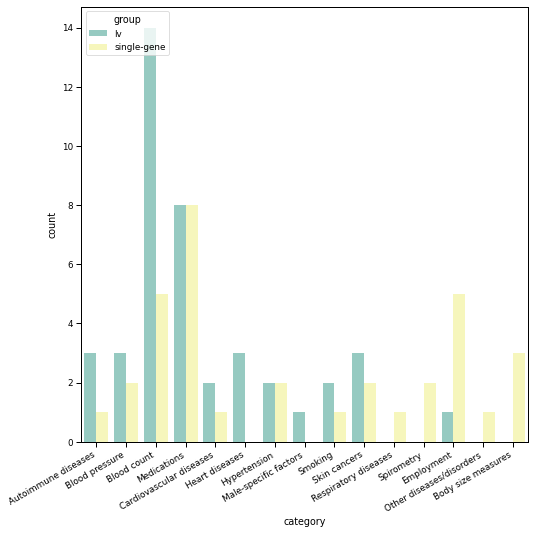

In [151]:
with sns.plotting_context("paper"):
    f, ax = plt.subplots(figsize=(8, 8))  # (figsize=(8, 8))
    ax = sns.countplot(
        x="category",
#         y="value",
        hue="group",
        order=_final_cat_order.index.drop_duplicates(keep="first").tolist(),
        data=_all_tmp,
        palette="Set3",
        ax=ax
    )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment="right")

# Venn diagram

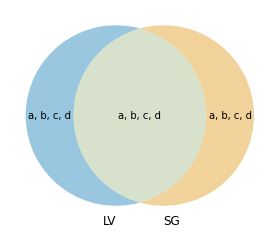

In [125]:
plt.figure()

_tmp = sns.color_palette("colorblind", 2)

_category = "Blood pressure"

_top_lv_traits = lv_traits.head(100)
_top_lv_traits = _top_lv_traits[_top_lv_traits["category"] == _category]["trait"]

_top_sg_traits = sg_traits.head(100)
_top_sg_traits = _top_sg_traits[_top_sg_traits["category"] == _category]["trait"]

# s1 = set(lv_traits_categories.head(10)["category"])
# s2 = set(sg_traits_categories.head(10)["category"])

s1 = set(_top_lv_traits)
s2 = set(_top_sg_traits)

v = mv.venn2([s1, s2], ["LV","SG"], set_colors=_tmp)
v.get_label_by_id('10').set_text('a, b, c, d')
v.get_label_by_id('11').set_text('a, b, c, d')
v.get_label_by_id('01').set_text('a, b, c, d')

In [119]:
_top_lv_traits.tolist()

['4079_raw-Diastolic_blood_pressure_automated_reading',
 '102_raw-Pulse_rate_automated_reading',
 '4080_raw-Systolic_blood_pressure_automated_reading']

In [120]:
_top_sg_traits.tolist()

['4079_raw-Diastolic_blood_pressure_automated_reading',
 '4080_raw-Systolic_blood_pressure_automated_reading',
 '94_raw-Diastolic_blood_pressure_manual_reading']

In [121]:
_tmp = sns.color_palette("hls", 2)